# Trabajo Práctico Nro 1 - Redes Neuronales, ITBA 2023
Autor: Pablo Smolkin

Legajo 59523
***

## Problema de Clasificación 

Se utilizará el dataset de Fashion MNIST, que se encuentra en la competencia de Kaggle [link](https://www.kaggle.com/t/5f2641ef201d4e8aa500d4876fb2b64e) que quedará abierta hasta el final de la cursada y otorgará puntos extras a los grupos ganadores. La competencia puede hacerse por grupos (la cantidad de integrantes que se deseen pero se reparten los puntos al final). La entrega del TP es individual.

### Imports

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

import datetime

### Load Dataset

In [2]:
x_data = np.load('../AssignmentGoodies/train_images.npy')
print(f"x data Shape: {x_data.shape}")

y_data = pd.read_csv('../AssignmentGoodies/train_labels.csv').to_numpy()[:,0]
print(f"y data Shape: {y_data.shape}")

x data Shape: (60000, 28, 28)
y data Shape: (60000,)


### 1. **EDA:** 
Visualizar algunas instancias de cada clase. Hacer histogramas de la distribución de intensidades para cada clase, cualquier otra propuesta es bienvenida.

In [3]:
# Find indexes of each class instance in y_data
class_examples = [np.where(y_data == i) for i in range(10)]

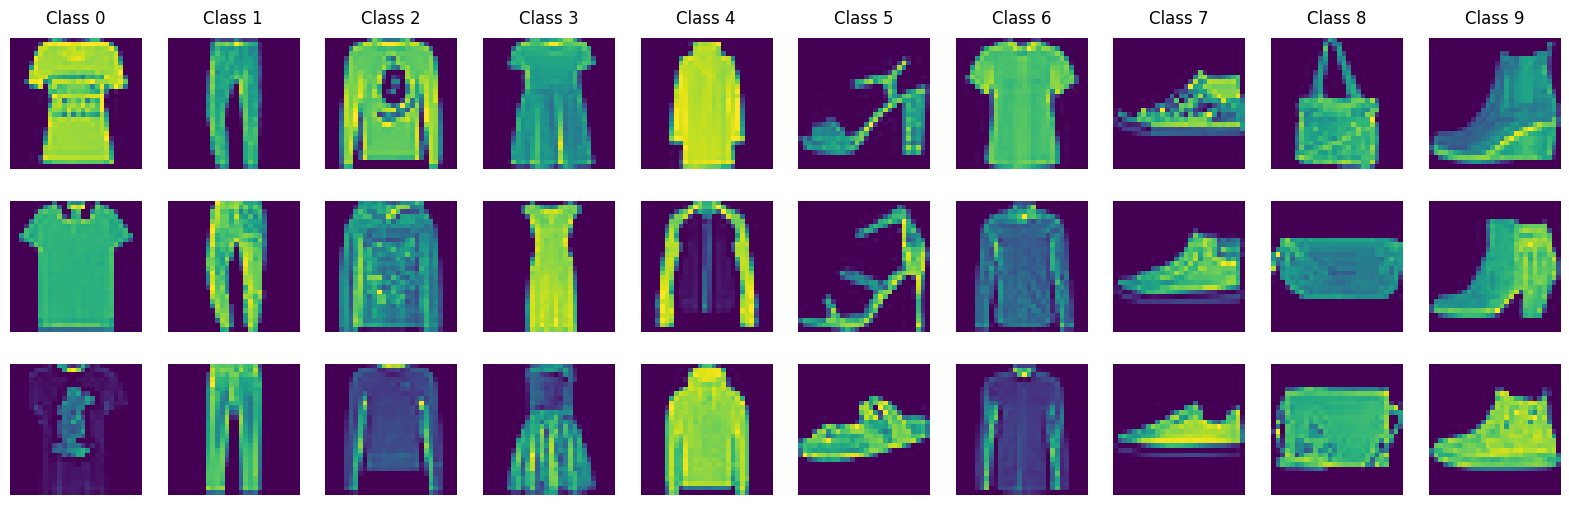

In [8]:
# Plot 3 random examples of each class
plt.figure(figsize=(20, 6))
for i in range(10):
    for j in range(3):
        plt.subplot(3, 10, i+1 + j*10)
        plt.imshow(x_data[class_examples[i][0][np.random.randint(0, 6000)], ...])
        plt.axis('off')
    plt.title(f'Class {i}', pad=245)
plt.show()

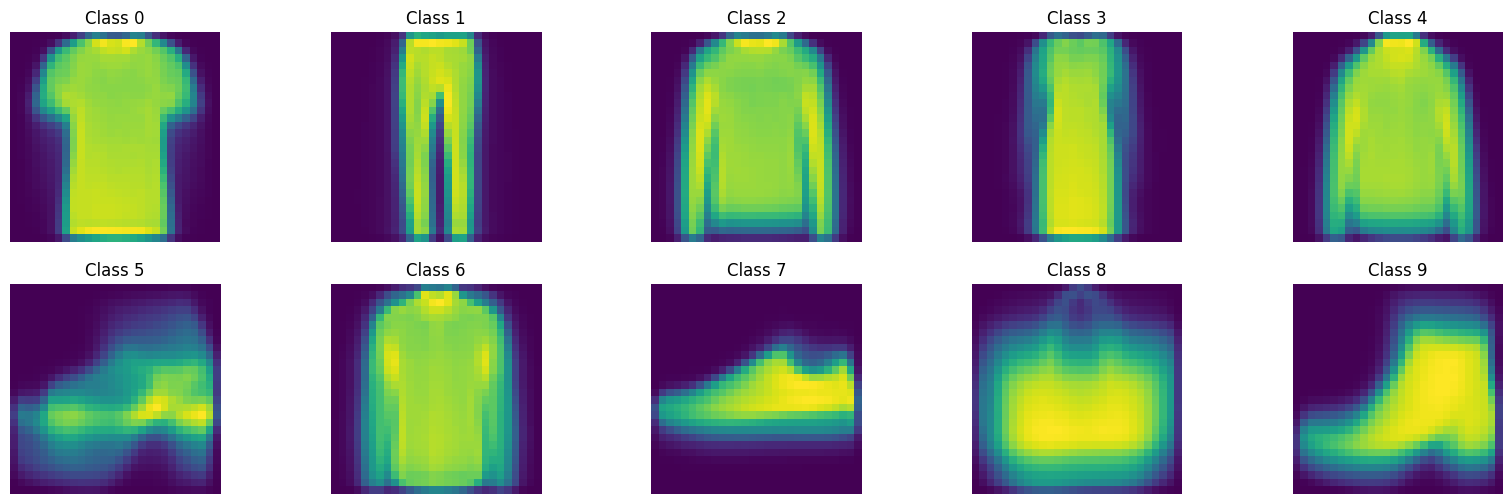

In [9]:
# Plot brightness mean of each class
plt.figure(figsize=(20, 6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(np.mean(x_data[class_examples[i][0], ...], axis=0))
    plt.axis('off')
    plt.title(f'Class {i}')

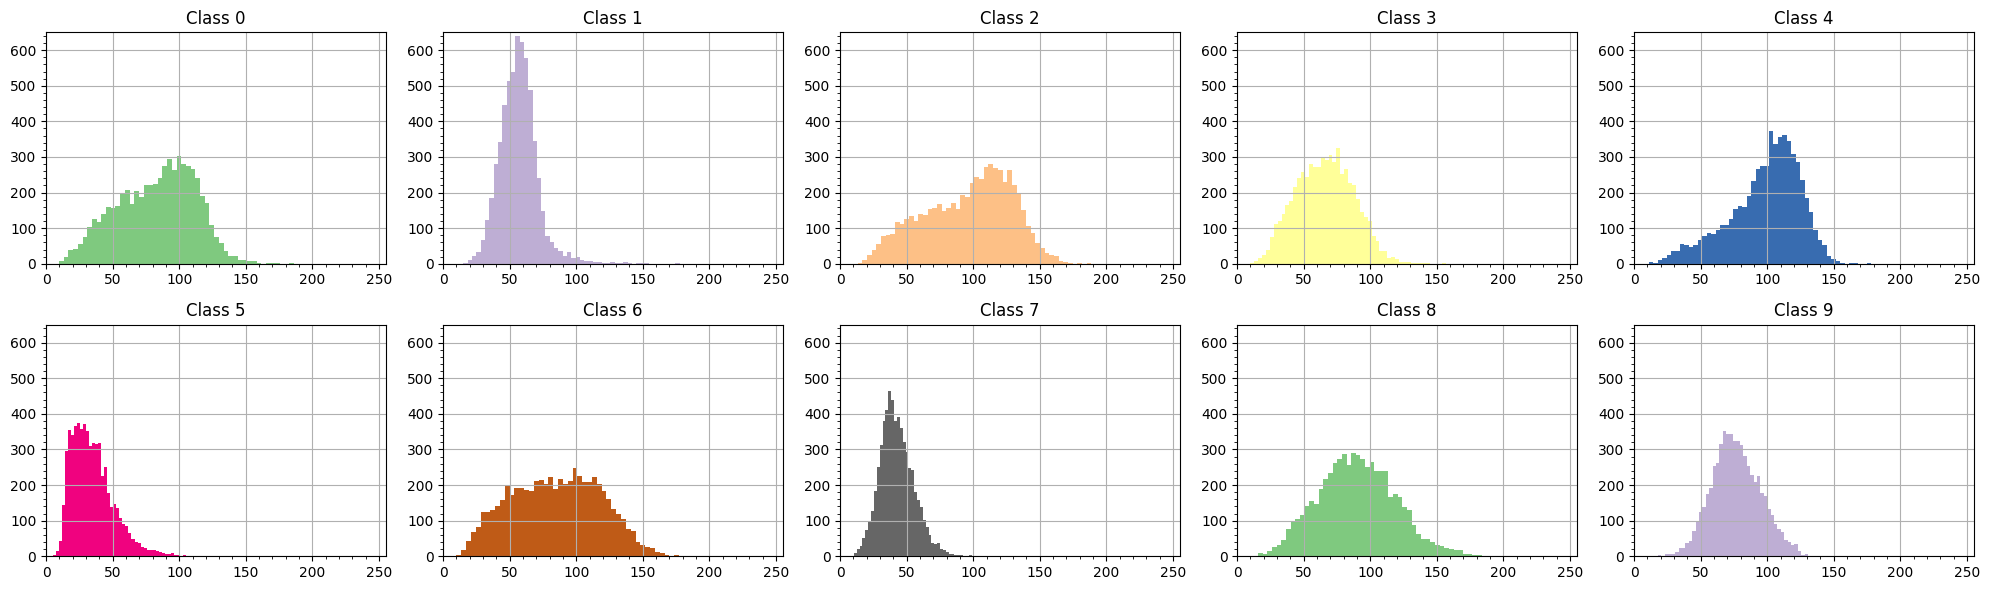

In [10]:
# Plot brightness distribution of each class
plt.figure(figsize=(20, 6))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.hist(np.mean(x_data[class_examples[i][0], ...], axis=(1,2)), color=plt.cm.Accent(i%8), bins=50)
    plt.grid()
    plt.xlim(0, 255)
    plt.ylim(0, 650)
    plt.minorticks_on()
    plt.tight_layout()
    plt.title(f'Class {i}')

### 2. **Modelos:** 
Entrenar un modelo de clasificación en las 10 clases de Fashion MNIST. Regresión softmax y MLP. En el caso que corresponda probar y comparar: distintas funciones de activación, distintos optimizadores, distintas funciones de costo, distintos tamaños de red (cantidad de capas y tamaño de cada capa), learning rate, batch_size, dropout rates, batch_normalization (si/no), inicializaciones de pesos (glorot_uniform, glorot_normal, normal(0,1), normal(0,0.001)).

Métricas a reportar para cada entrenamiento de interés: Accuracy como métrica principal.
Como métricas secundarias: curva ROC, área bajo la curva ROC, F1-score, Precisión y
Recall. Enunciar para el F1-score y el área bajo la curva ROC cómo se calculan los
promedios macro y micro. Justificar cuál de los dos es el que corresponde reportar en este
problema.

Para un buen modelo obtenido en el punto anterior (así si lo mejoran no tienen que repetir
este punto), variar los hiperparámetros de a uno y graficar:

* Accuracy vs [LEARNING_RATE, BATCH_SIZE, OPTIMIZADORES, ACTIVACIONES, DROPOUT_RATE, BATCH_NORMALIZATION, INICIALIZACIONES DE PESOS]

* Iteraciones de entrenamiento vs [LEARNING_RATE, BATCH_SIZE, OPTIMIZADORES, ACTIVACIONES, DROPOUT_RATE, BATCH_NORMALIZATION, INICIALIZACIONES DE PESOS]

Intente justificar los gráficos obtenidos. Valores mínimos esperados para cada modelo: SoftmaxReg: .70, MLP: .83

#### Softmax

In [3]:
# Normalize the data
scaler = StandardScaler()
x_stand = scaler.fit_transform(x_data.reshape(-1, 784)).reshape(-1, 28, 28)

In [4]:
# Split the train_valid sub-dataset into train and valid
x_train, x_valid, y_train, y_valid = train_test_split(x_stand, y_data, test_size=1/3, random_state=10, shuffle=True)

In [5]:
print(x_train.shape, x_valid.shape, y_train.shape, y_valid.shape)

(40000, 28, 28) (20000, 28, 28) (40000,) (20000,)


In [6]:
# Make sparce label vectors
y_sparse_train = np.zeros([40000,10])
y_sparse_valid = np.zeros([20000,10])
for idx in range(40000):
    y_sparse_train[idx,y_train[idx]] = 1
for idx in range(20000):
    y_sparse_valid[idx,y_valid[idx]] = 1

In [7]:
# Loading TensorBoard for learning logging
%load_ext tensorboard

In [8]:
# Softmax model
softReg = Sequential()
softReg.add(Flatten(input_shape=(28,28)))
softReg.add(Dense(10, activation="softmax"))
softReg.summary()
softReg.compile(loss = "categorical_crossentropy", optimizer=Adam(learning_rate=0.0001),metrics=["accuracy"])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [9]:
# Configuring TensorBoard to log learning process
log_dir = "../logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

In [10]:
earlyStopping = EarlyStopping(monitor='accuracy', patience=10, verbose=0, mode='min')

In [11]:
history = softReg.fit(x= x_train, y = y_sparse_train, validation_data=(x_valid, y_sparse_valid), batch_size = 32, epochs=100, callbacks=[earlyStopping, tensorboard_callback])

Epoch 1/100
1250/1250 [==============================] - 4s 3ms/step - loss: 0.8648 - accuracy: 0.7004 - val_loss: 0.6322 - val_accuracy: 0.7811
Epoch 2/100
1250/1250 [==============================] - 3s 3ms/step - loss: 0.5639 - accuracy: 0.8063 - val_loss: 0.5447 - val_accuracy: 0.8109
Epoch 3/100
1250/1250 [==============================] - 3s 3ms/step - loss: 0.5077 - accuracy: 0.8265 - val_loss: 0.5110 - val_accuracy: 0.8231
Epoch 4/100
1250/1250 [==============================] - 3s 3ms/step - loss: 0.4794 - accuracy: 0.8363 - val_loss: 0.4915 - val_accuracy: 0.8301
Epoch 5/100
1250/1250 [==============================] - 3s 3ms/step - loss: 0.4616 - accuracy: 0.8421 - val_loss: 0.4795 - val_accuracy: 0.8346
Epoch 6/100
1250/1250 [==============================] - 3s 3ms/step - loss: 0.4486 - accuracy: 0.8473 - val_loss: 0.4702 - val_accuracy: 0.8388
Epoch 7/100
1250/1250 [==============================] - 3s 3ms/step - loss: 0.4386 - accuracy: 0.8504 - val_loss: 0.4652 - val_ac

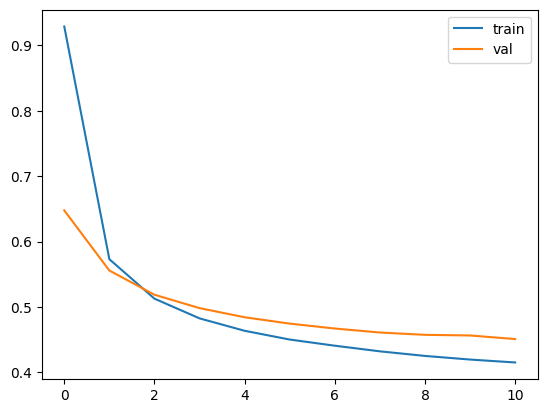

In [17]:
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.legend()
plt.show()

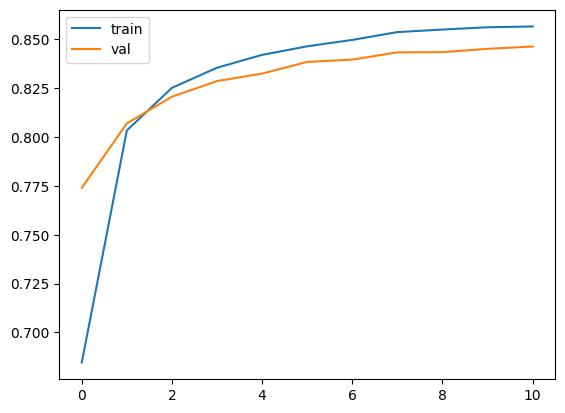

Max Accuracy: 0.8566
Max Val Accuracy: 0.8464


In [18]:
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="val")
plt.legend()
plt.show()
maxAccuracy = max(history.history["accuracy"])
maxValAccuracy = max(history.history["val_accuracy"])
print(f"Max Accuracy: {maxAccuracy:.4f}")
print(f"Max Val Accuracy: {maxValAccuracy:.4f}")

#### MLP

In [23]:
# Normalize the data
scaler = StandardScaler()
x_stand = scaler.fit_transform(x_data.reshape(-1, 784)).reshape(-1, 28, 28)

In [24]:
# Split the train_valid sub-dataset into train and valid
x_train, x_valid, y_train, y_valid = train_test_split(x_stand, y_data, test_size=1/3, random_state=10, shuffle=True)

In [25]:
print(x_train.shape, x_valid.shape, y_train.shape, y_valid.shape)

(40000, 28, 28) (20000, 28, 28) (40000,) (20000,)


In [26]:
# Make sparce label vectors
y_sparse_train = np.zeros([40000,10])
y_sparse_valid = np.zeros([20000,10])
for idx in range(40000):
    y_sparse_train[idx,y_train[idx]] = 1
for idx in range(20000):
    y_sparse_valid[idx,y_valid[idx]] = 1

In [27]:
# Softmax model
model = Sequential()
model.add(Flatten(input_shape=(28,28)))
model.add(Dense(100, activation="relu"))
model.add(Dense(10, activation="softmax"))
model.summary()
model.compile(loss = "categorical_crossentropy", optimizer=Adam(learning_rate=0.0001),metrics=["accuracy"])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_1 (Dense)             (None, 100)               78500     
                                                                 
 dense_2 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


In [28]:
earlyStopping = EarlyStopping(monitor='val_accuracy', patience=10, verbose=0, mode='max')
history = model.fit(x= x_train, y = y_sparse_train, validation_data=(x_valid, y_sparse_valid), batch_size = 32, epochs=100, callbacks=[earlyStopping])

Epoch 1/100
1250/1250 [==============================] - 5s 3ms/step - loss: 0.6621 - accuracy: 0.7766 - val_loss: 0.4868 - val_accuracy: 0.8286
Epoch 2/100
1250/1250 [==============================] - 4s 3ms/step - loss: 0.4244 - accuracy: 0.8512 - val_loss: 0.4258 - val_accuracy: 0.8508
Epoch 3/100
1250/1250 [==============================] - 4s 3ms/step - loss: 0.3758 - accuracy: 0.8680 - val_loss: 0.4016 - val_accuracy: 0.8597
Epoch 4/100
1250/1250 [==============================] - 4s 3ms/step - loss: 0.3469 - accuracy: 0.8788 - val_loss: 0.3861 - val_accuracy: 0.8616
Epoch 5/100
1250/1250 [==============================] - 4s 3ms/step - loss: 0.3258 - accuracy: 0.8852 - val_loss: 0.3706 - val_accuracy: 0.8687
Epoch 6/100
1250/1250 [==============================] - 4s 3ms/step - loss: 0.3087 - accuracy: 0.8909 - val_loss: 0.3668 - val_accuracy: 0.8686
Epoch 7/100
1250/1250 [==============================] - 4s 3ms/step - loss: 0.2953 - accuracy: 0.8946 - val_loss: 0.3559 - val_ac

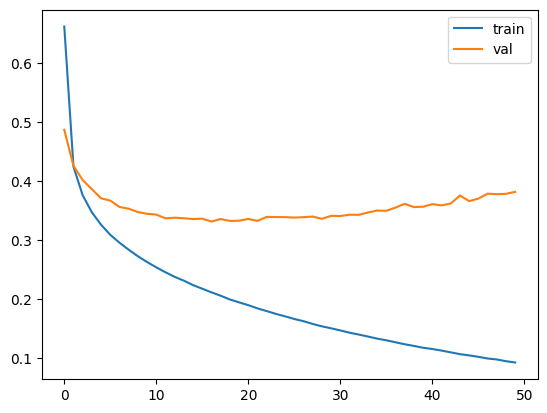

In [29]:
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.legend()
plt.show()

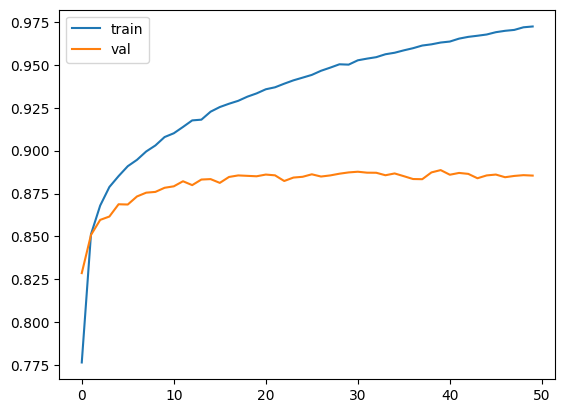

Max Accuracy: 0.9723
Max Val Accuracy: 0.8887


In [30]:
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="val")
plt.legend()
plt.show()
maxAccuracy = max(history.history["accuracy"])
maxValAccuracy = max(history.history["val_accuracy"])
print(f"Max Accuracy: {maxAccuracy:.4f}")
print(f"Max Val Accuracy: {maxValAccuracy:.4f}")

### 3. 
El mejor modelo debe ser reentrenado agregando una capa de tamaño 2 antes de la de salida. Mapear los datos de entrada a la salida de la capa agregada y graficarla con los labels correspondientes. Superponer en el mismo gráfico los umbrales de decisión. Para obtener los umbrales de decisión se debe armar una grilla de puntos que debe darse como input a la última capa de la red neuronal (softmax) y tomar el argumento máximo como clase correspondiente.
   
Se alienta a intentar aumentar los datos de entrenamiento haciendo espejamiento de las imágenes en las situaciones que tenga sentido hacerlo. 

Una vez entregado el TP se pueden seguir subiendo predicciones de modelos nuevos a Kaggle hasta el final de la cursada.

### 4. Para un buen conjunto de hiperparámetros de un MLP obtenido en 2, entrenar de la siguiente manera:
* Salvar la red inicializada con pesos aleatorios (antes de entrenar). La llamaremos red 1.
* Entrenar la red. La llamaremos red 2.
* Comparar los pesos obtenidos en red 2 con los pesos de inicialización (red 1) y marcar a aquel 50% que más haya variado.
* Sobre la red 1 eliminar los pesos que no hayan sido marcados en el punto anterior. La llamaremos red 3.
* Sin entrenar, medir el accuracy de red 3.
* Entrenar la red 3 (de 1/2 del tamaño original) y comparar la métrica con la métrica obtenida con red 2.
* Discutiremos los resultados en clase.

***

## Problema de Regresión

***

## Testing Code

In [49]:
x_data = np.load('../AssignmentGoodies/train_images.npy')
print(x_data.shape)

y_data = pd.read_csv('../AssignmentGoodies/train_labels.csv').to_numpy()[:,0]
print(y_data.shape)

(60000, 28, 28)
(60000,)


In [50]:
y_data.shape

(60000,)

In [51]:
y_data[0]

9

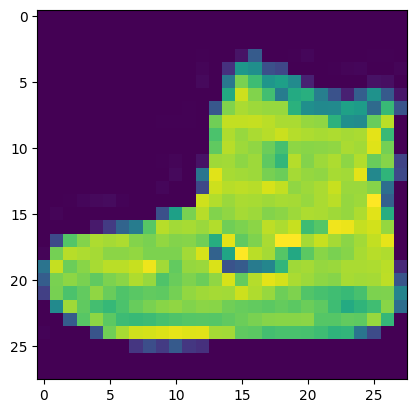

In [52]:
plt.imshow(x_data[0,...])

In [53]:
from sklearn import model_selection

In [54]:
# Split the train_valid sub-dataset into train and valid
x_train, x_valid, y_train, y_valid = model_selection.train_test_split(x_data, y_data, test_size=1/3, random_state=10, shuffle=True)

In [55]:
x_train, x_valid = x_train / 255.0, x_valid / 255.0

In [56]:
print(x_train.shape, x_valid.shape, y_train.shape, y_valid.shape)

(40000, 28, 28) (20000, 28, 28) (40000,) (20000,)


In [57]:
y_sparse_train = np.zeros([40000,10])
y_sparse_valid = np.zeros([20000,10])

In [58]:
for idx in range(40000):
    y_sparse_train[idx,y_train[idx]] = 1

for idx in range(20000):
    y_sparse_valid[idx,y_valid[idx]] = 1

In [59]:
y_sparse_train[0]

array([0., 0., 0., 0., 0., 0., 1., 0., 0., 0.])

In [60]:
y_sparse_valid[0]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])

In [61]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [40]:
model =  Sequential()

In [41]:
model.add(Flatten(input_shape=(28,28)))

In [42]:
model.add(Dense(100, activation="relu"))
model.add(Dense(10, activation="softmax"))

In [43]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 784)               0         
                                                                 
 dense_4 (Dense)             (None, 100)               78500     
                                                                 
 dense_5 (Dense)             (None, 10)                1010      
                                                                 
Total params: 79,510
Trainable params: 79,510
Non-trainable params: 0
_________________________________________________________________


In [44]:
model.compile(loss = "categorical_crossentropy", optimizer=Adam(learning_rate=0.0001),metrics=["accuracy"])

In [45]:
earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')
history = model.fit(x= x_train, y = y_sparse_train, validation_data=(x_valid, y_sparse_valid), batch_size = 32, epochs=100, callbacks=[earlyStopping])

Epoch 1/100
1250/1250 [==============================] - 7s 5ms/step - loss: 0.8138 - accuracy: 0.7472 - val_loss: 0.5825 - val_accuracy: 0.8087
Epoch 2/100
1250/1250 [==============================] - 8s 6ms/step - loss: 0.5229 - accuracy: 0.8283 - val_loss: 0.5025 - val_accuracy: 0.8327
Epoch 3/100
1250/1250 [==============================] - 8s 6ms/step - loss: 0.4698 - accuracy: 0.8409 - val_loss: 0.4742 - val_accuracy: 0.8394
Epoch 4/100
1250/1250 [==============================] - 8s 6ms/step - loss: 0.4389 - accuracy: 0.8496 - val_loss: 0.4491 - val_accuracy: 0.8461
Epoch 5/100
1250/1250 [==============================] - 6s 5ms/step - loss: 0.4195 - accuracy: 0.8572 - val_loss: 0.4337 - val_accuracy: 0.8515
Epoch 6/100
1250/1250 [==============================] - 6s 5ms/step - loss: 0.4034 - accuracy: 0.8615 - val_loss: 0.4212 - val_accuracy: 0.8571
Epoch 7/100
1250/1250 [==============================] - 7s 5ms/step - loss: 0.3921 - accuracy: 0.8644 - val_loss: 0.4131 - val_ac

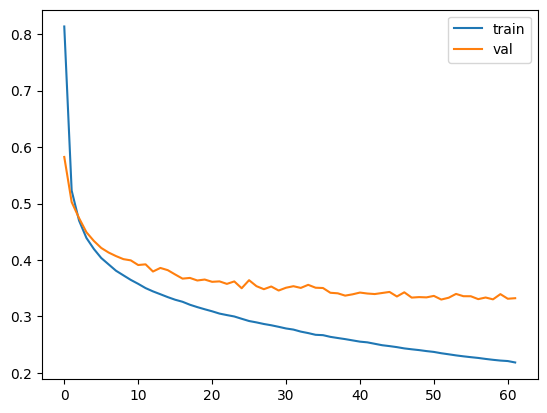

In [46]:
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.legend()
plt.show()

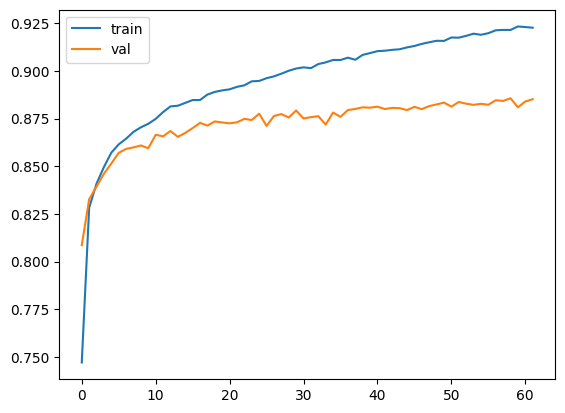

Max Accuracy: 0.9233
Max Val Accuracy: 0.8856


In [47]:
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="val")
plt.legend()
plt.show()
maxAccuracy = max(history.history["accuracy"])
maxValAccuracy = max(history.history["val_accuracy"])
print(f"Max Accuracy: {maxAccuracy:.4f}")
print(f"Max Val Accuracy: {maxValAccuracy:.4f}")

### Con Conv2D

In [71]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn import model_selection

fashion_mnist = np.load('../AssignmentGoodies/train_images.npy')
print(fashion_mnist.shape)
x_data = fashion_mnist
y_data = pd.read_csv('../AssignmentGoodies/train_labels.csv').to_numpy()[:,0]
print(y_data.shape)

# Split the train_valid sub-dataset into train and valid
x_train, x_valid, y_train, y_valid = model_selection.train_test_split(x_data, y_data, test_size=1/3, random_state=10, shuffle=True)

x_train, x_valid = x_train / 255.0, x_valid / 255.0

y_sparse_train = np.zeros([40000,10])
y_sparse_valid = np.zeros([20000,10])

for idx in range(40000):
    y_sparse_train[idx,y_train[idx]] = 1

for idx in range(20000):
    y_sparse_valid[idx,y_valid[idx]] = 1

model = Sequential()
model.add(Conv2D(32, 3, activation='relu', input_shape=(28,28,1)))
model.add(Flatten(input_shape=(28,28)))
model.add(Dense(128, activation="relu", kernel_initializer="glorot_normal"))
model.add(Dense(10, activation="softmax", kernel_initializer="glorot_normal"))

model.compile(loss = "categorical_crossentropy", optimizer=Adam(learning_rate=0.0001, amsgrad=True),metrics=["accuracy"])

earlyStopping = EarlyStopping(monitor='val_loss', patience=10, verbose=0, mode='min')

(60000, 28, 28)
(60000,)


In [72]:
history = model.fit(x= x_train, y = y_sparse_train, validation_data=(x_valid, y_sparse_valid), batch_size = 32, epochs=100, callbacks=[earlyStopping])

Epoch 1/100
1250/1250 [==============================] - 22s 17ms/step - loss: 0.5323 - accuracy: 0.8179 - val_loss: 0.4441 - val_accuracy: 0.8456
Epoch 2/100
1250/1250 [==============================] - 18s 14ms/step - loss: 0.3756 - accuracy: 0.8673 - val_loss: 0.3706 - val_accuracy: 0.8712
Epoch 3/100
1250/1250 [==============================] - 8s 6ms/step - loss: 0.3286 - accuracy: 0.8845 - val_loss: 0.3430 - val_accuracy: 0.8809
Epoch 4/100
1250/1250 [==============================] - 13s 10ms/step - loss: 0.2982 - accuracy: 0.8953 - val_loss: 0.3300 - val_accuracy: 0.8842
Epoch 5/100
1250/1250 [==============================] - 14s 11ms/step - loss: 0.2780 - accuracy: 0.9006 - val_loss: 0.3152 - val_accuracy: 0.8884
Epoch 6/100
1250/1250 [==============================] - 9s 7ms/step - loss: 0.2591 - accuracy: 0.9081 - val_loss: 0.3250 - val_accuracy: 0.8852
Epoch 7/100
1250/1250 [==============================] - 10s 8ms/step - loss: 0.2442 - accuracy: 0.9128 - val_loss: 0.3036

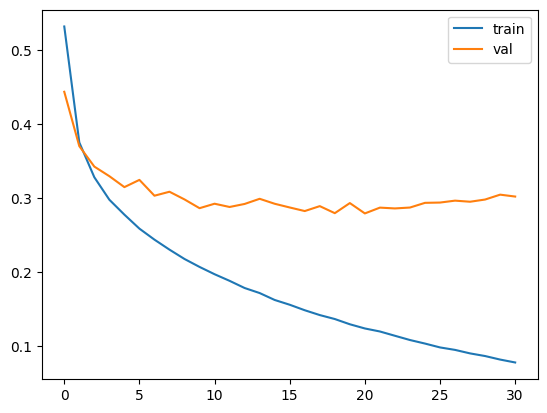

In [73]:
plt.plot(history.history["loss"], label="train")
plt.plot(history.history["val_loss"], label="val")
plt.legend()
plt.show()

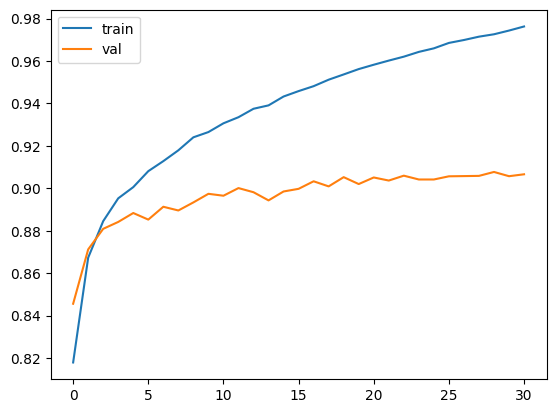

Max Accuracy: 0.9762
Max Val Accuracy: 0.9077


In [74]:
plt.plot(history.history["accuracy"], label="train")
plt.plot(history.history["val_accuracy"], label="val")
plt.legend()
plt.show()
maxAccuracy = max(history.history["accuracy"])
maxValAccuracy = max(history.history["val_accuracy"])
print(f"Max Accuracy: {maxAccuracy:.4f}")
print(f"Max Val Accuracy: {maxValAccuracy:.4f}")

In [63]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Flatten, Conv2D
from tensorflow.keras import Model

x_train_c = x_train[..., tf.newaxis]
x_valid_c = x_valid[..., tf.newaxis]

train_ds = tf.data.Dataset.from_tensor_slices(
    (x_train_c, y_train)).shuffle(10000).batch(32)
test_ds = tf.data.Dataset.from_tensor_slices((x_valid_c, y_valid)).batch(32)

class MyModel(Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv1 = Conv2D(32, 3, activation='relu')
        self.flatten = Flatten()
        self.d1 = Dense(128, activation='relu')
        self.d2 = Dense(10, activation='softmax')

    def call(self, x):
        x = self.conv1(x)
        x = self.flatten(x)
        x = self.d1(x)
        return self.d2(x)


model = MyModel()

loss_object = tf.keras.losses.SparseCategoricalCrossentropy()

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

train_loss = tf.keras.metrics.Mean(name='train_loss')
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='train_accuracy')

test_loss = tf.keras.metrics.Mean(name='test_loss')
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy(
    name='test_accuracy')


@tf.function
def train_step(images, labels):
    with tf.GradientTape() as tape:
        predictions = model(images)
        loss = loss_object(labels, predictions)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))

    train_loss(loss)
    train_accuracy(labels, predictions)


@tf.function
def test_step(images, labels):
    predictions = model(images)
    t_loss = loss_object(labels, predictions)

    test_loss(t_loss)
    test_accuracy(labels, predictions)


EPOCHS = 30

for epoch in range(EPOCHS):
    train_loss.reset_states()
    train_accuracy.reset_states()
    test_loss.reset_states()
    test_accuracy.reset_states()

    for images, labels in train_ds:
        train_step(images, labels)

    for test_images, test_labels in test_ds:
        test_step(test_images, test_labels)

    template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
    print(template.format(epoch+1,
                          train_loss.result(),
                          train_accuracy.result()*100,
                          test_loss.result(),
                          test_accuracy.result()*100))

Epoch 1, Loss: 0.5348147749900818, Accuracy: 81.82250213623047, Test Loss: 0.42223048210144043, Test Accuracy: 85.16999816894531
Epoch 2, Loss: 0.3641526997089386, Accuracy: 87.28250122070312, Test Loss: 0.3585905134677887, Test Accuracy: 87.43000030517578
Epoch 3, Loss: 0.3172007203102112, Accuracy: 88.86000061035156, Test Loss: 0.333437442779541, Test Accuracy: 88.15499877929688
Epoch 4, Loss: 0.28587308526039124, Accuracy: 89.90499877929688, Test Loss: 0.3143055737018585, Test Accuracy: 88.92499542236328
Epoch 5, Loss: 0.2647632360458374, Accuracy: 90.59249877929688, Test Loss: 0.32276687026023865, Test Accuracy: 88.38999938964844
Epoch 6, Loss: 0.24431802332401276, Accuracy: 91.36499786376953, Test Loss: 0.29318392276763916, Test Accuracy: 89.375
Epoch 7, Loss: 0.22861969470977783, Accuracy: 91.84249877929688, Test Loss: 0.28849902749061584, Test Accuracy: 89.59500122070312
Epoch 8, Loss: 0.21358607709407806, Accuracy: 92.37249755859375, Test Loss: 0.28478309512138367, Test Accurac